All images loaded successfully.

Processing Part 1...


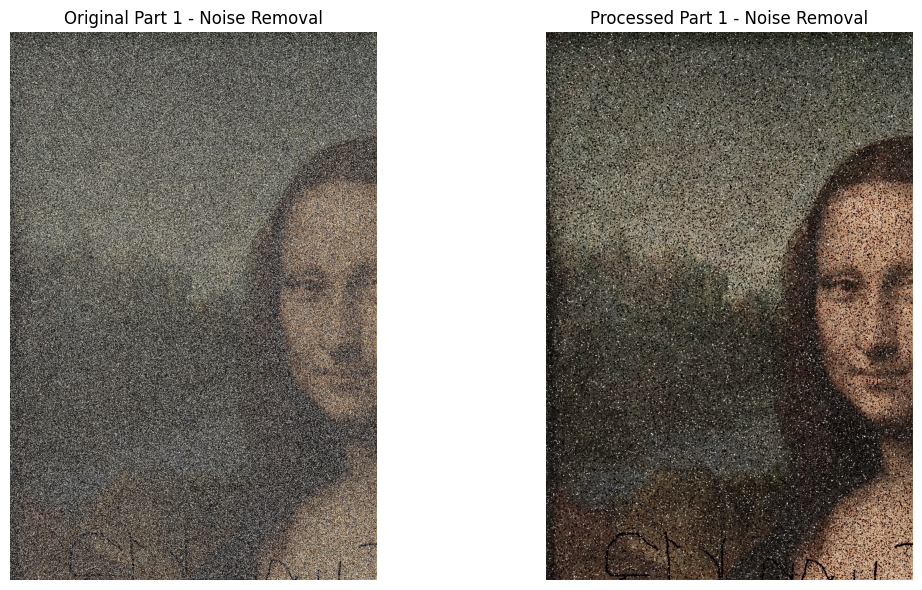


Processing Part 2...


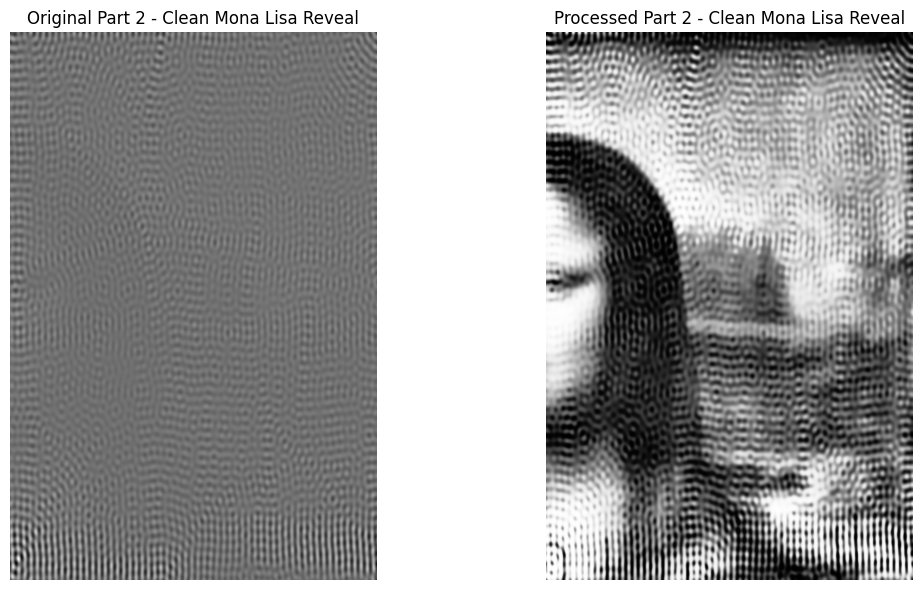

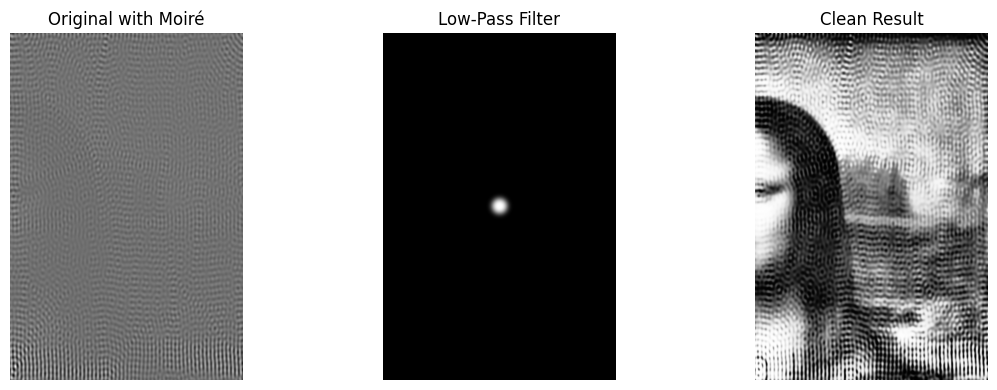


Processing Part 3...


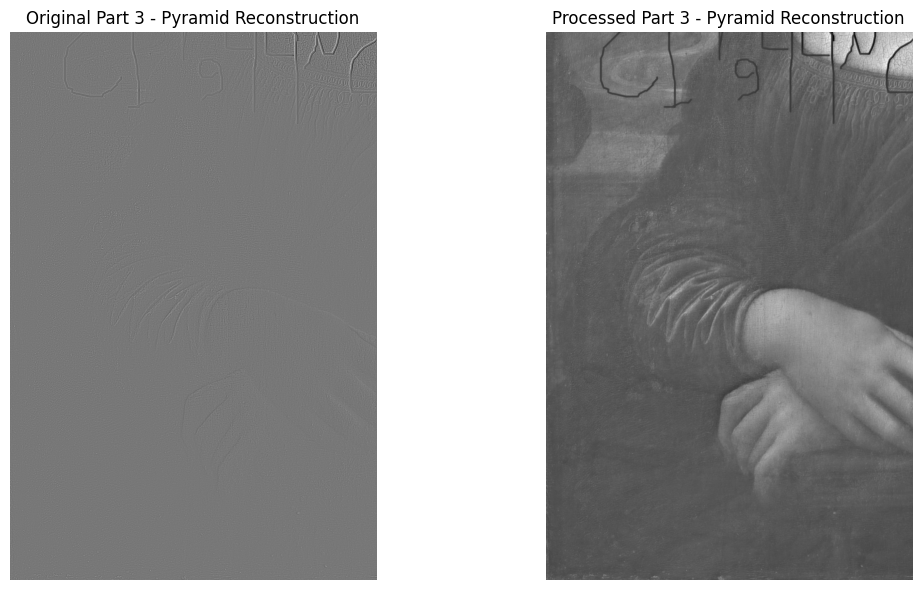


Processing Part 4...


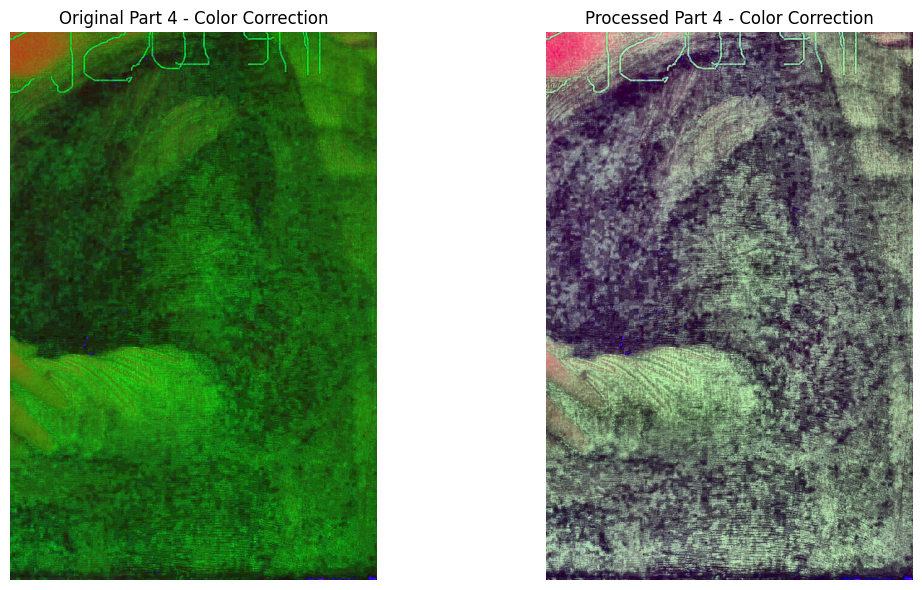


Stitching all processed parts...


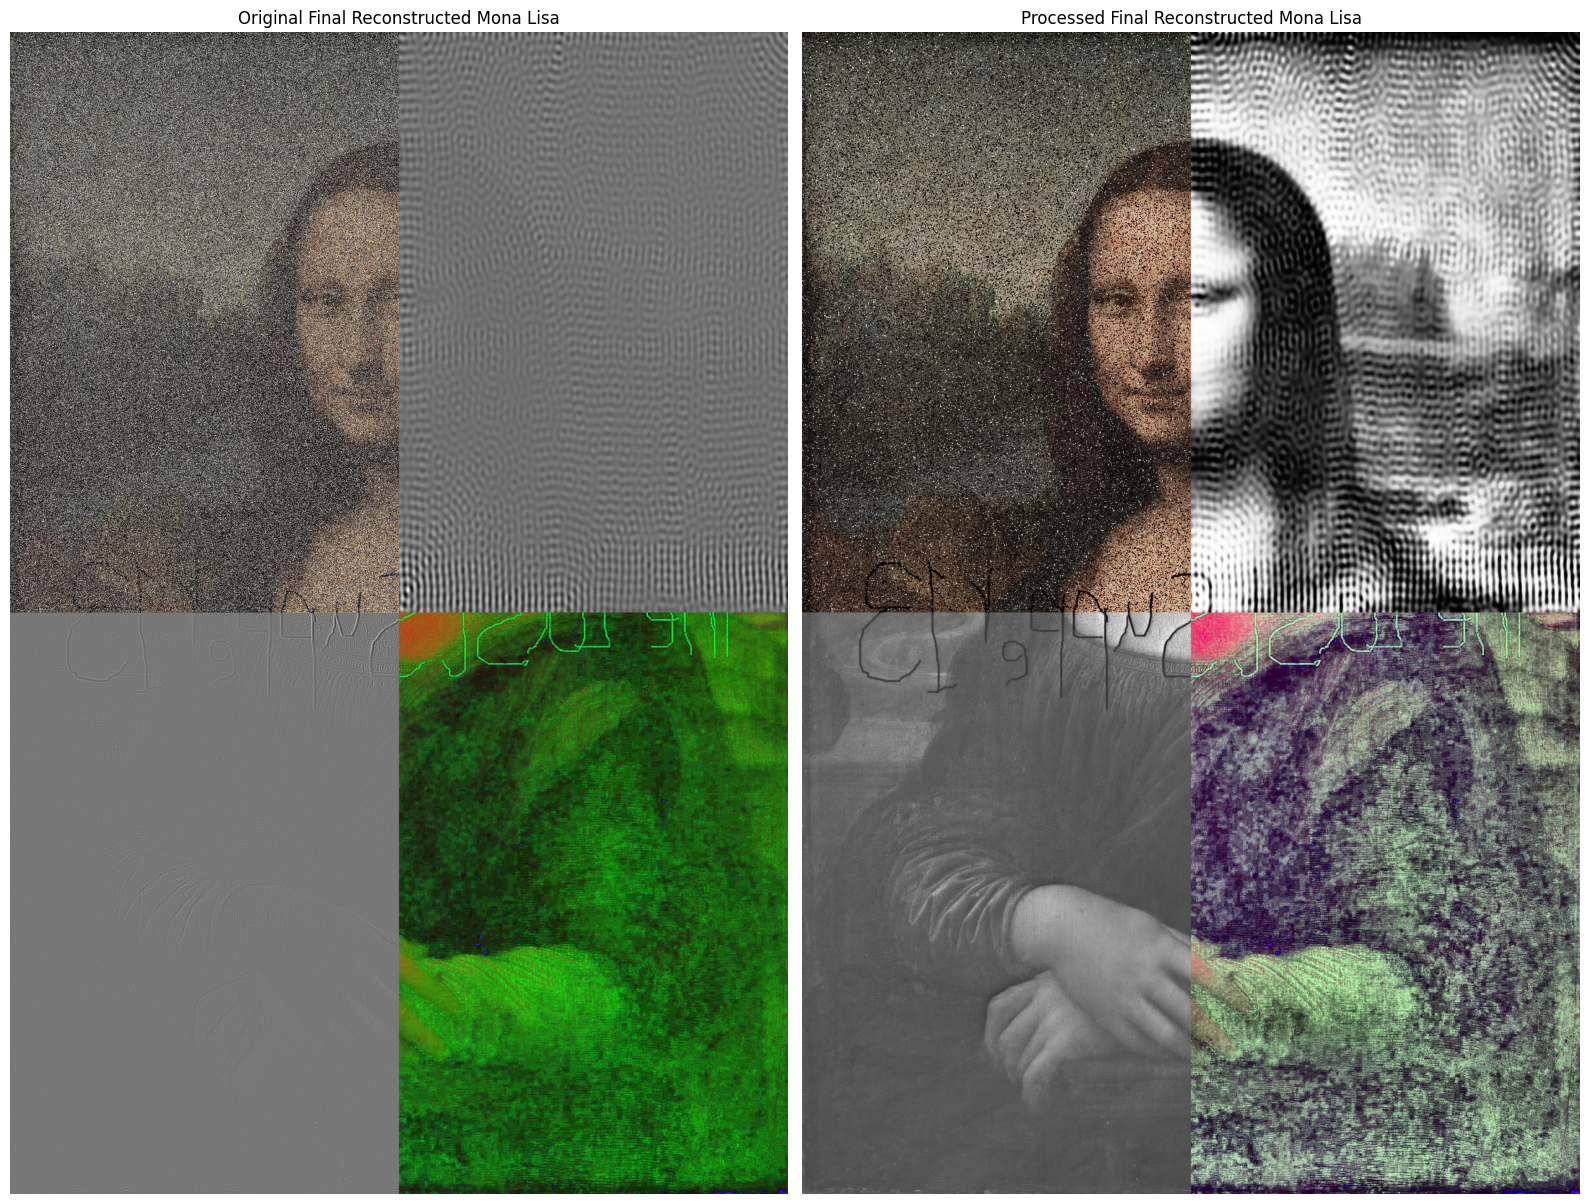


Processing complete! Reconstructed image saved as 'reconstructed_mona_lisa.jpg'


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def show_comparison(original, processed, title, figsize=(12, 6)):
    """Shows a side-by-side comparison of original vs. processed images."""
    plt.figure(figsize=figsize)
    # Ensure images are in a displayable format
    original_display = cv2.cvtColor(original, cv2.COLOR_BGR2RGB) if len(original.shape) == 3 and original.shape[2] == 3 else original
    processed_display = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB) if len(processed.shape) == 3 and processed.shape[2] == 3 else processed

    plt.subplot(1, 2, 1)
    plt.imshow(original_display, cmap='gray')
    plt.title(f'Original {title}')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(processed_display, cmap='gray')
    plt.title(f'Processed {title}')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# --- Image Loading ---
try:
    image_paths = {
        'part_1': 'Q1/processed_img_part_1.jpg',
        'part_2': 'Q1/processed_img_part_2.jpg',
        'part_3_level_0': 'Q1/processed_img_part_3_Level_0.jpg',
        'part_3_level_1': 'Q1/processed_img_part_3_Level_1.jpg',
        'part_3_level_2': 'Q1/processed_img_part_3_Level_2.jpg',
        'part_3_level_3': 'Q1/processed_img_part_3_Level_3.jpg',
        'part_3_level_4': 'Q1/processed_img_part_3_Level_4.jpg',
        'part_4': 'Q1/processed_img_part_4.jpg'
    }
    images = {key: cv2.imread(path, cv2.IMREAD_UNCHANGED) for key, path in image_paths.items()}
    if any(img is None for img in images.values()):
        raise FileNotFoundError
except FileNotFoundError:
    print("Error: Could not load one or more images. Please check the file paths.")
    exit()

print("All images loaded successfully.")

# --- Part 1: Salt-and-Pepper Noise Removal ---
print("\nProcessing Part 1...")
part_1_original = images['part_1'].copy()
# Median filter is excellent for salt-and-pepper noise.
# Then, Non-Local Means Denoising cleans up remaining general noise.
denoised_median = cv2.medianBlur(part_1_original, 3)
processed_part_1 = cv2.fastNlMeansDenoisingColored(denoised_median, None, 10, 10, 7, 21)
images['processed_part_1'] = processed_part_1
show_comparison(part_1_original, processed_part_1, "Part 1 - Noise Removal")

# --- Part 2: Aggressive Moiré Pattern Removal to Reveal Mona Lisa ---
# Complete removal of periodic interference to show the actual painting underneath
print("\nProcessing Part 2...")
part_2_original = images['part_2'].copy()
# Ensure image is grayscale for FFT
part_2_gray = cv2.cvtColor(part_2_original, cv2.COLOR_BGR2GRAY) if len(part_2_original.shape) == 3 else part_2_original

# Method 1: Aggressive Low-Pass Filtering in Frequency Domain
f_transform = np.fft.fft2(part_2_gray.astype(np.float32))
f_shift = np.fft.fftshift(f_transform)

# Create a strong low-pass filter to completely remove high-frequency moiré
rows, cols = part_2_gray.shape
crow, ccol = rows // 2, cols // 2

# Create a Gaussian low-pass filter
D0 = 33  # Cutoff frequency - adjust this to control how much detail to keep
H = np.zeros((rows, cols), dtype=np.float32)
for u in range(rows):
    for v in range(cols):
        D = np.sqrt((u - crow)**2 + (v - ccol)**2)
        H[u, v] = np.exp(-(D**3) / (2 * (D0**3)))

# Apply the filter
f_filtered = f_shift * H
f_ishift = np.fft.ifftshift(f_filtered)
img_filtered = np.fft.ifft2(f_ishift)
img_filtered = np.abs(img_filtered)

# Method 2: Combine with adaptive histogram equalization
img_normalized = cv2.normalize(img_filtered, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Strong adaptive histogram equalization to bring out the image
clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(4,4))
img_clahe = clahe.apply(img_normalized)

# Method 3: Apply strong denoising
# Use Non-local Means Denoising to remove remaining pattern noise
img_denoised = cv2.fastNlMeansDenoising(img_clahe, None, 10, 7, 21)

# Method 4: Edge-preserving smoothing to clean up while keeping boundaries
# Apply bilateral filter multiple times for stronger effect
img_smooth = img_denoised.copy()
for i in range(3):  # Multiple iterations for stronger smoothing
    img_smooth = cv2.bilateralFilter(img_smooth, 9, 80, 80)

# Method 5: Final contrast enhancement
# Apply gamma correction to brighten the image
gamma = 1.2
img_gamma = np.power(img_smooth / 255.0, gamma) * 255.0
img_gamma = img_gamma.astype(np.uint8)

# Apply final histogram equalization
processed_part_2 = cv2.equalizeHist(img_gamma)

# Alternative approach if the above is still too noisy:
# Simple aggressive smoothing approach

images['processed_part_2'] = processed_part_2
show_comparison(part_2_original, processed_part_2, "Part 2 - Clean Mona Lisa Reveal")

#  Show the frequency domain processing steps
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(part_2_gray, cmap='gray')
plt.title('Original with Moiré')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(H, cmap='gray')
plt.title('Low-Pass Filter')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(processed_part_2, cmap='gray')
plt.title('Clean Result')
plt.axis('off')

plt.tight_layout()
plt.show()


# --- Part 3: Laplacian Pyramid Reconstruction ---
# The 5 levels of Part 3 form a Laplacian pyramid. They must be reconstructed sequentially from smallest to largest.
print("\nProcessing Part 3...")
levels = [images[f'part_3_level_{i}'] for i in range(5)]
# Ensure all levels are grayscale for consistency
levels_gray = [cv2.cvtColor(level, cv2.COLOR_BGR2GRAY) if len(level.shape) == 3 else level for level in levels]

# Start with the smallest image (Level 4)
reconstructed = levels_gray[4].astype(np.float32)

# Iteratively upsample and add the detail layers from Level 3 down to 0
for i in range(3, -1, -1):
    # Upsample the current reconstructed image to the size of the next level
    h, w = levels_gray[i].shape[:2]
    reconstructed_upsampled = cv2.pyrUp(reconstructed, dstsize=(w, h))
    # Add the detail layer (laplacian) from the current level
    reconstructed = cv2.add(reconstructed_upsampled, levels_gray[i].astype(np.float32))

# Normalize the final result to be a visible image
processed_part_3 = cv2.normalize(reconstructed, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
images['processed_part_3'] = processed_part_3
show_comparison(images['part_3_level_0'], processed_part_3, "Part 3 - Pyramid Reconstruction")


# --- Part 4: Color Correction ---
# The goal is to remove the heavy green cast or convert to a high-quality black and white image.
print("\nProcessing Part 4...")
part_4_original = images['part_4'].copy()

# The best way to correct a color cast is in the LAB color space.
# L = Lightness, a = Green-Magenta, b = Blue-Yellow
lab_image = cv2.cvtColor(part_4_original, cv2.COLOR_BGR2Lab)
l_channel, a_channel, b_channel = cv2.split(lab_image)

# To remove the green cast, we need to reduce the green/increase the magenta in the 'a' channel.
# We calculate the mean of the 'a' and 'b' channels. An ideal neutral color has a=128, b=128.
a_mean = np.mean(a_channel)
b_mean = np.mean(b_channel)
# Calculate the shift needed to move the average 'a' and 'b' towards neutral (128)
a_shift = 128 - a_mean
b_shift = 128 - b_mean

# Apply the correction to each pixel
a_corrected = cv2.add(a_channel, int(a_shift))
b_corrected = cv2.add(b_channel, int(b_shift))

# Merge the corrected channels back and convert to BGR
corrected_lab = cv2.merge([l_channel, a_corrected, b_corrected])
processed_part_4 = cv2.cvtColor(corrected_lab, cv2.COLOR_Lab2BGR)

# As a final touch, apply a small amount of CLAHE to the lightness channel to improve local contrast
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
l_channel = clahe.apply(l_channel)
final_lab = cv2.merge([l_channel, a_corrected, b_corrected])
processed_part_4 = cv2.cvtColor(final_lab, cv2.COLOR_Lab2BGR)

images['processed_part_4'] = processed_part_4
show_comparison(part_4_original, processed_part_4, "Part 4 - Color Correction")


# --- Final Stitching ---
print("\nStitching all processed parts...")

# Define processed and original parts for stitching
p1, p2, p3, p4 = images['processed_part_1'], images['processed_part_2'], images['processed_part_3'], images['processed_part_4']
o1, o2, o3, o4 = images['part_1'], images['part_2'], images['part_3_level_0'], images['part_4']

# Find a common size for all quadrants (using the smallest dimensions to avoid upscaling artifacts)
h_min = min(p1.shape[0], p2.shape[0], p3.shape[0], p4.shape[0])
w_min = min(p1.shape[1], p2.shape[1], p3.shape[1], p4.shape[1])
common_size = (w_min, h_min)

# Prepare lists for easier processing
processed_parts = [p1, p2, p3, p4]
original_parts = [o1, o2, o3, o4]

# Resize and ensure all parts are 3-channel BGR for stacking
for i in range(4):
    processed_parts[i] = cv2.resize(processed_parts[i], common_size, interpolation=cv2.INTER_LANCZOS4)
    original_parts[i] = cv2.resize(original_parts[i], common_size, interpolation=cv2.INTER_LANCZOS4)
    if len(processed_parts[i].shape) == 2:
        processed_parts[i] = cv2.cvtColor(processed_parts[i], cv2.COLOR_GRAY2BGR)
    if len(original_parts[i].shape) == 2:
        original_parts[i] = cv2.cvtColor(original_parts[i], cv2.COLOR_GRAY2BGR)

# Unpack for clarity
p1, p2, p3, p4 = processed_parts
o1, o2, o3, o4 = original_parts

# Stack the images to reconstruct the Mona Lisa
# Arrangement: | 1 | 2 |
#              | 3 | 4 |
final_image = np.vstack((np.hstack((p1, p2)), np.hstack((p3, p4))))
original_combined = np.vstack((np.hstack((o1, o2)), np.hstack((o3, o4))))

# Show final result and save
show_comparison(original_combined, final_image, "Final Reconstructed Mona Lisa", figsize=(16,16))
cv2.imwrite('reconstructed_mona_lisa.jpg', final_image)
print("\nProcessing complete! Reconstructed image saved as 'reconstructed_mona_lisa.jpg'")